# import libreries for the experiment

In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
    
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import captum

from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocess_utils 
import models  
import train_utils 
import plot_utils
import train
import analyse_layer

# Getting landmarks from WLASL 100 dataset

In [3]:
# define directories
#root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/prototypewlasl/WLASL100'
#save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarksprototypewlasl100/'

# 25fps (default)
# get media pipe landmarks
#result= prepare_datasets.get_landmarks_WLASL100(root, prepare_datasets.wlasl100class_names, frame_numbers= 30)

In [4]:
#np.save(os.path.join(save_dir, 'detections.npy'), np.array(result[0]))     
#with open(os.path.join(save_dir, 'labels.json'), 'w') as file:
    #json.dump(result[1], file) 

# loading saved landmarks from WLASL 100 dataset

In [20]:
root_dir= os.path.dirname(os.getcwd())   # defining path to project folder
data_dir= os.path.join(root_dir, 'data') # path to dataset directories

wlasl= os.path.join(data_dir, 'landmarksprototypewlasl100') # path to WLASL 100 directory

# loading detections and labels for WLASL dataset
wlasl100_detections= np.load(os.path.join(wlasl, 'detections.npy'), allow_pickle=True)
with open(os.path.join(wlasl, 'labels.json'), 'r') as file:
     wlasl100_labels= json.load(file)

In [21]:
wlasl100_detections.shape, len(wlasl100_labels)

((1181, 25, 1662), 1181)

# visualizing how interpolation works

In [16]:
video_detection_1= wlasl100_detections[2]   # video 1
video_detection_2= wlasl100_detections[6]  # video 2
frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)]  # order of the landmarks: pose, face, lh, rh
ivd= preprocess_utils.interpolate_video_detections(video_detection_1, video_detection_2, frame_structure, 0.5)
video_detection_1.shape, video_detection_2.shape, ivd.shape

((25, 1662), (25, 1662), (25, 1662))

In [8]:
plot_utils.show_video_detections(video_detection_1)

In [9]:
plot_utils.show_video_detections(video_detection_2)

In [10]:
plot_utils.show_video_detections(ivd)

# Connecting Cuda

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU
(8, 6)


# Eliminating face landmark: for faster training

In [18]:
pose = np.arange(0, 132)
lh_and_rh = np.arange(1536, 1662)
indices_to_keep = np.concatenate((pose, lh_and_rh))   # Concatenate indices to keep
filtered_detections = wlasl100_detections[:, :, indices_to_keep] # Filter the data to remove face landmarks
filtered_detections.shape

(1181, 25, 258)

In [22]:
wlasl100_detections, wlasl100_labels = preprocess_utils.interpolate_dataset(wlasl100_detections, wlasl100_labels, alpha= 0.5, num_interpolation_samples= 9)
wlasl100_detections, wlasl100_labels = resample(wlasl100_detections, wlasl100_labels, n_samples=4000, random_state=42)
wlasl100_detections.shape, len(wlasl100_labels)

((4000, 25, 1662), 4000)

In [23]:
pose = np.arange(0, 132)
lh_and_rh = np.arange(1536, 1662)
indices_to_keep = np.concatenate((pose, lh_and_rh))   # Concatenate indices to keep
filtered_detections = wlasl100_detections[:, :, indices_to_keep] # Filter the data to remove face landmarks
filtered_detections.shape

(4000, 25, 258)

# prepare data for experiment

In [27]:
X, y= preprocess_utils.convert(detections= filtered_detections,
                               labels= wlasl100_labels,
                               class_names= prepare_datasets.wlasl100class_names) 

dataset = train.CustomDataset(X, y)

In [28]:
video_detection, label = dataset[0]

In [29]:
model= models.PETransformer(class_names= prepare_datasets.wlasl100class_names,
                            seq_len= 25, 
                            d_model= 258,
                            nhead= 6,
                            d_ff= 512, 
                            num_layers= 1)

In [30]:
sailency= Saliency(forward_func= model)

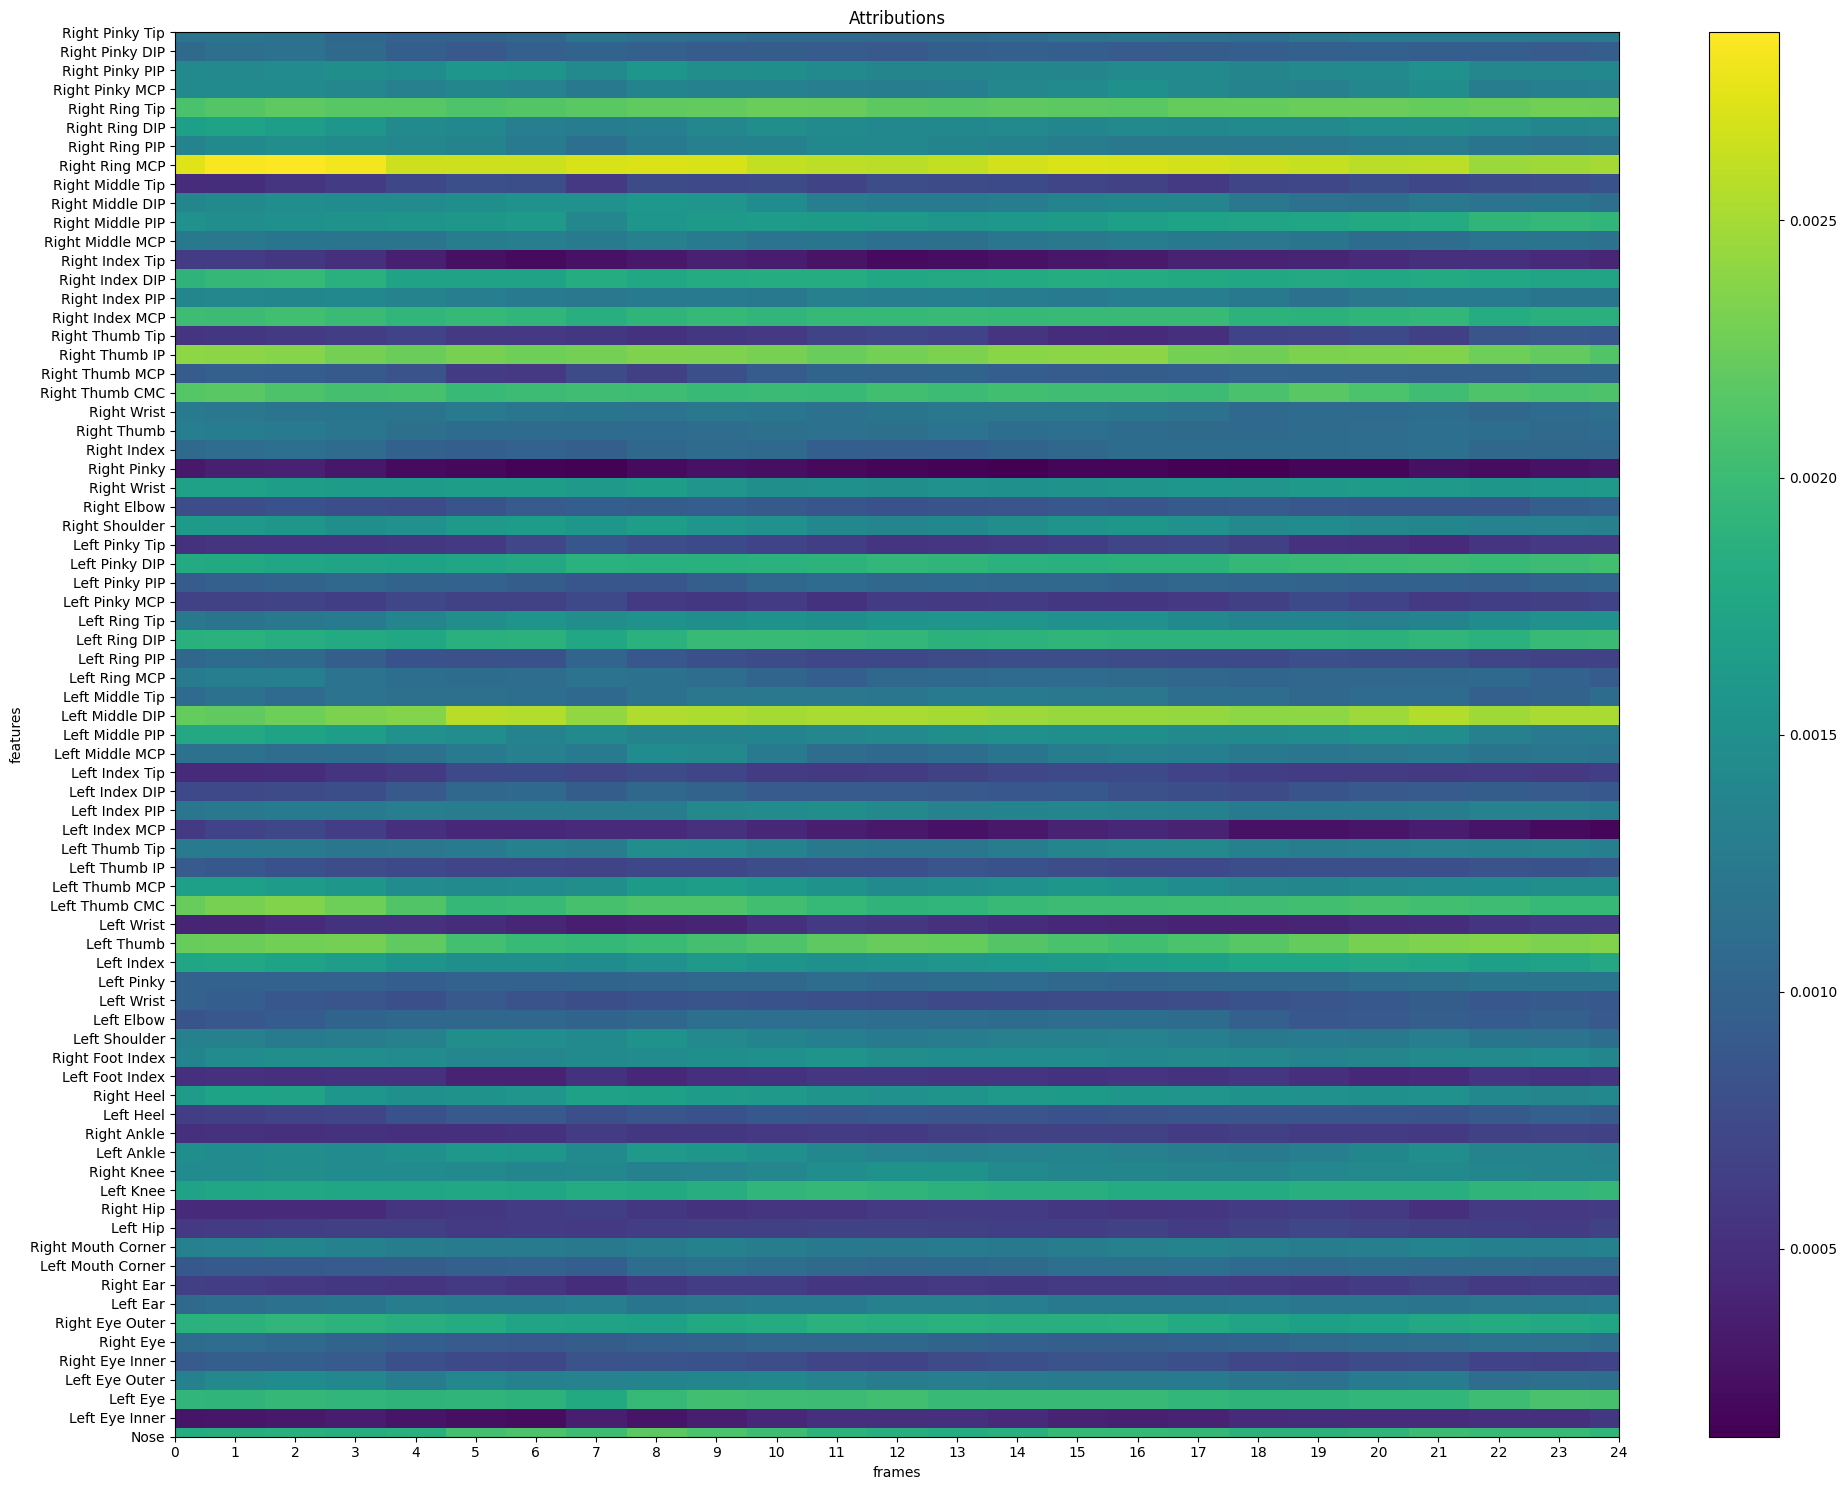

In [31]:
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection,
                                                     label= label,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= None, show_landmark_names= True)

  0%|          | 0/4000 [00:00<?, ?it/s]

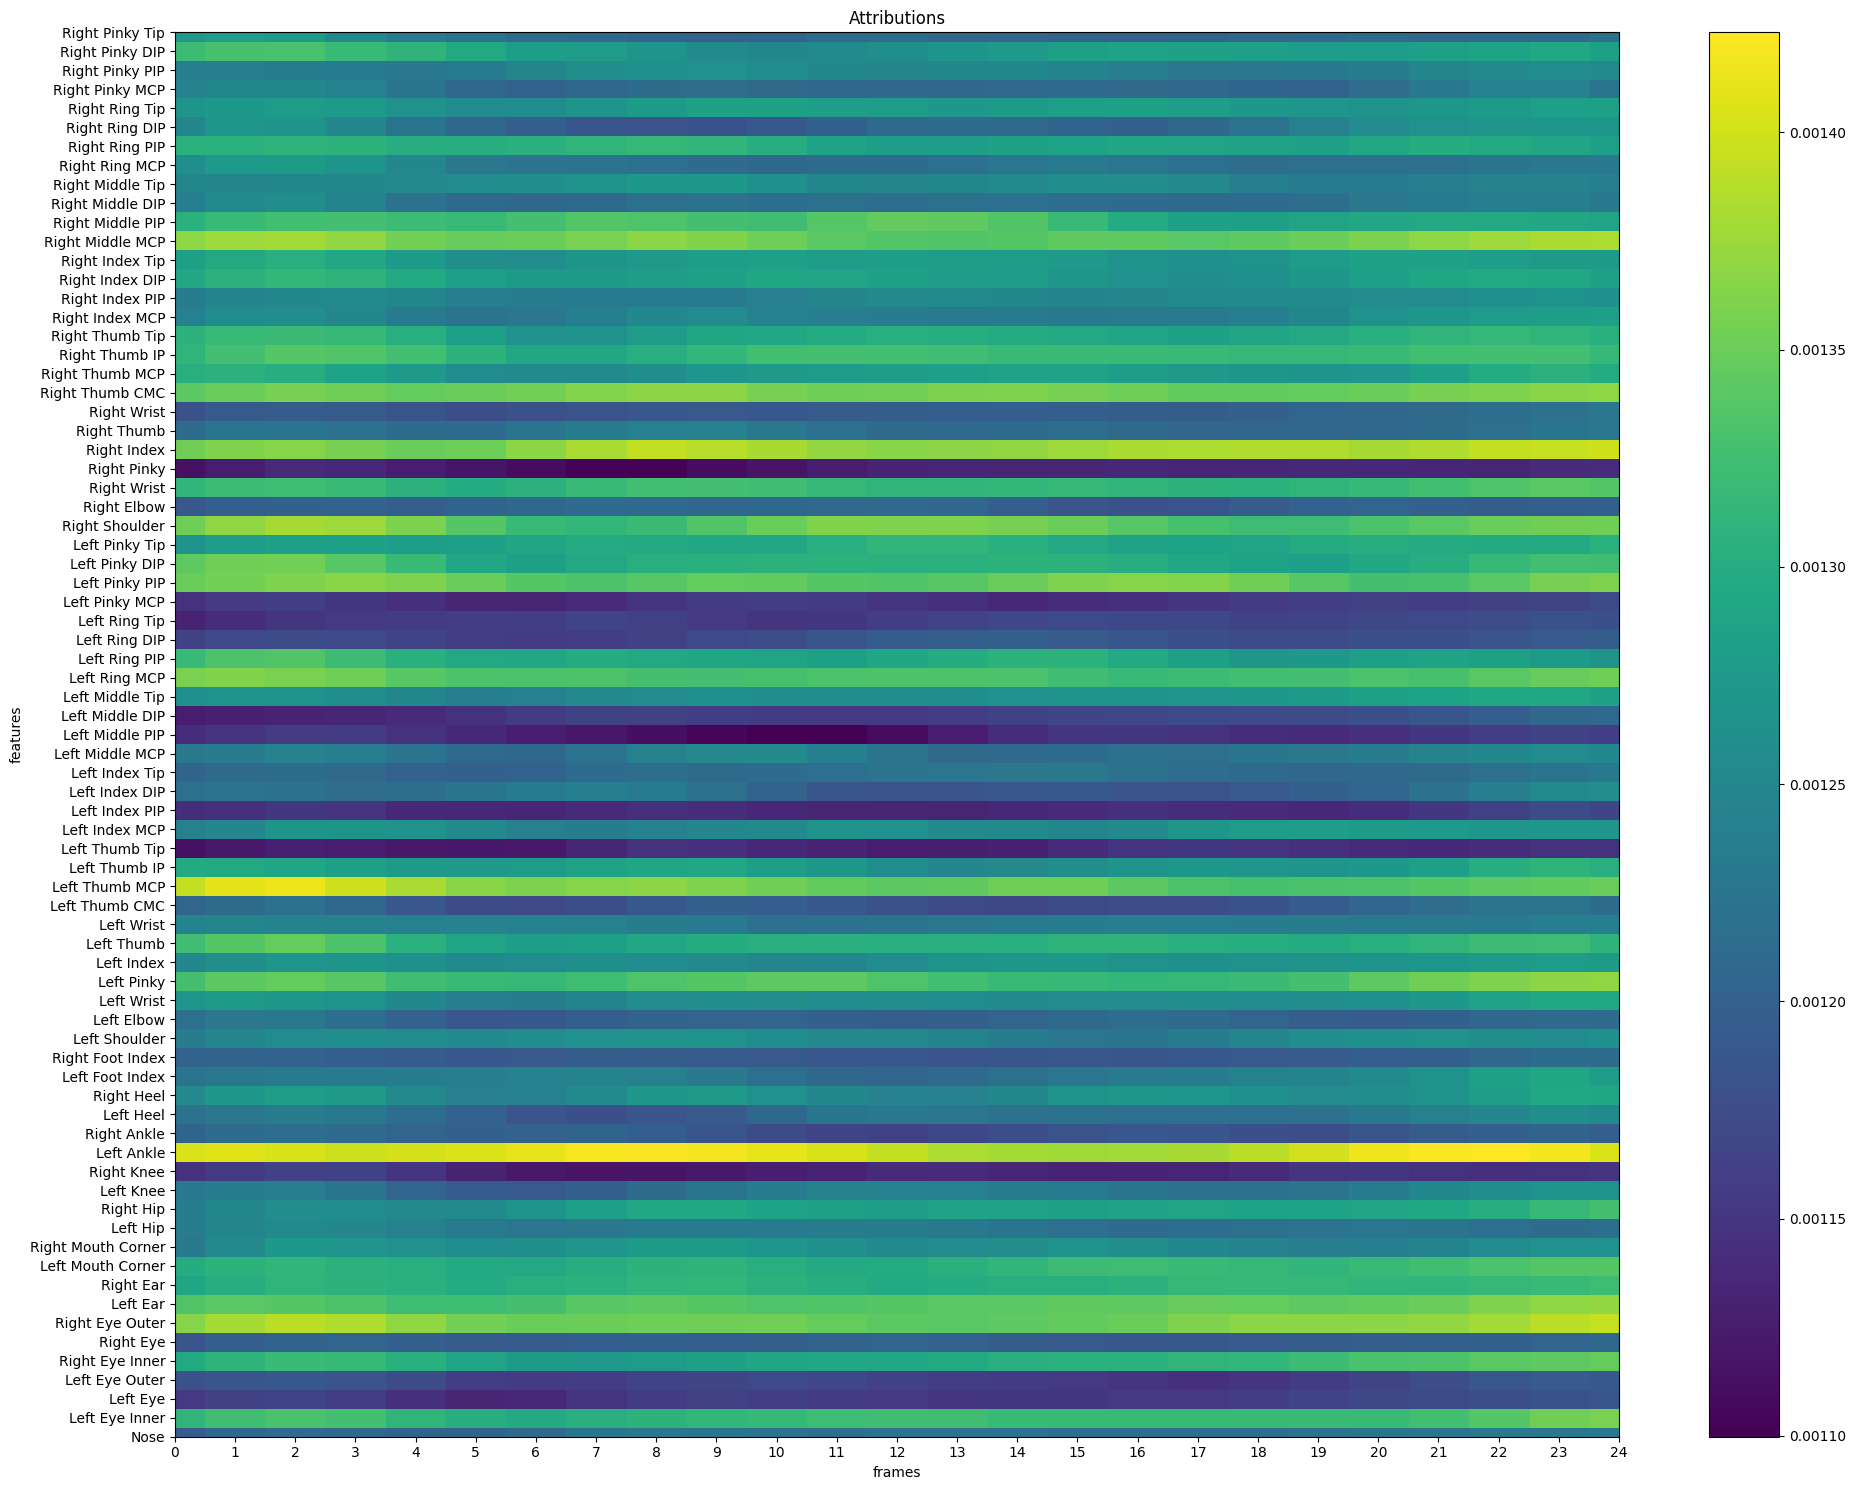

In [32]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= None, show_landmark_names= True)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

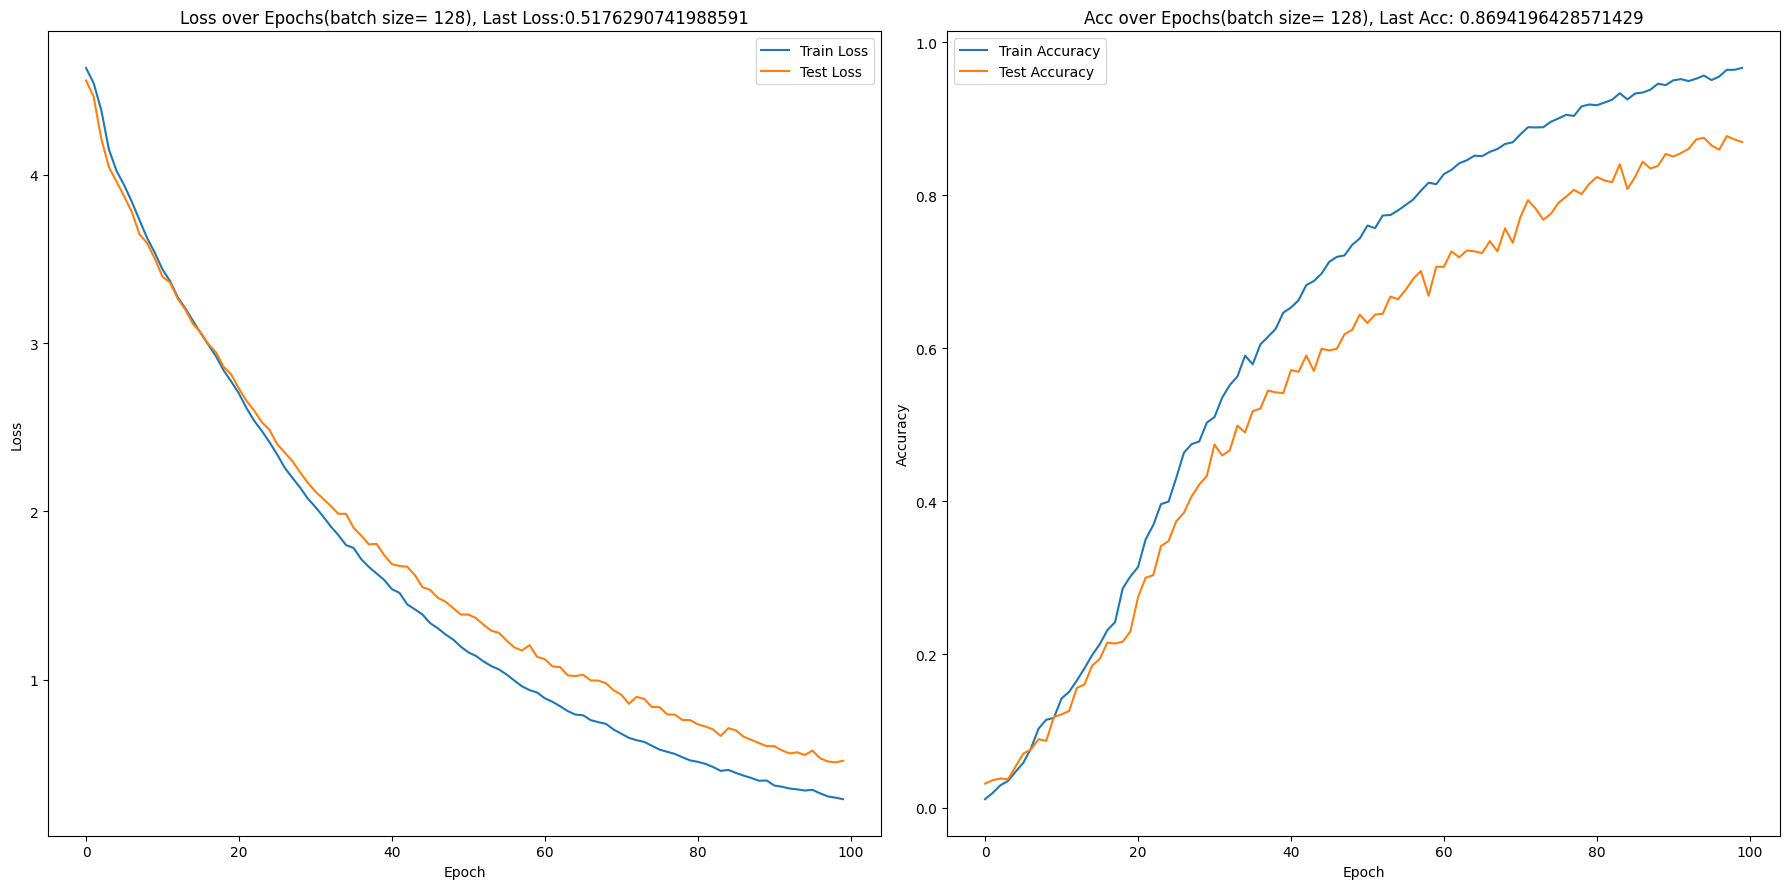

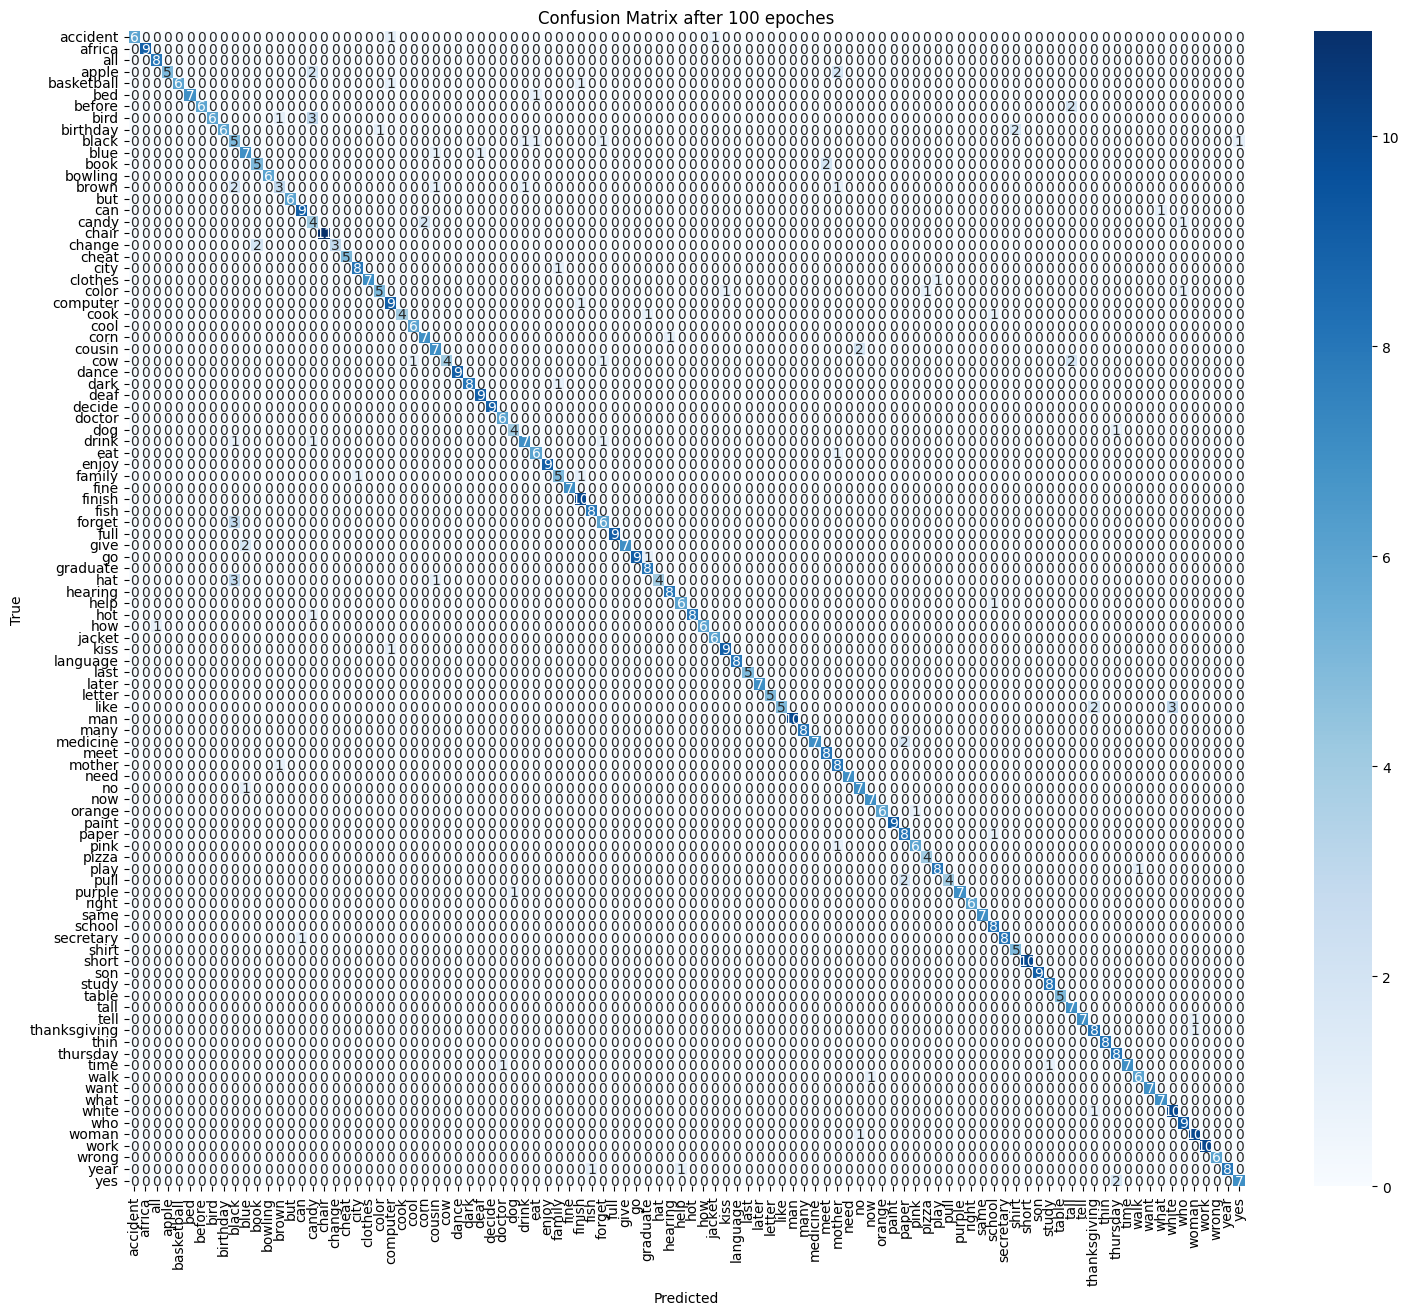

In [34]:
train.configure(detections= filtered_detections,
                labels= wlasl100_labels,
                class_names= prepare_datasets.wlasl100class_names, 
                test_size= 0.2, 
                batch_size= 128,
                num_epochs= 100,
                model= model,
                lr= 0.0001,
                device= device,
                quick_save= False,
                results_name= '25fps_b_128_nl_2_nh_3_lr_0001',
                dataset_name= 'WLASL100')

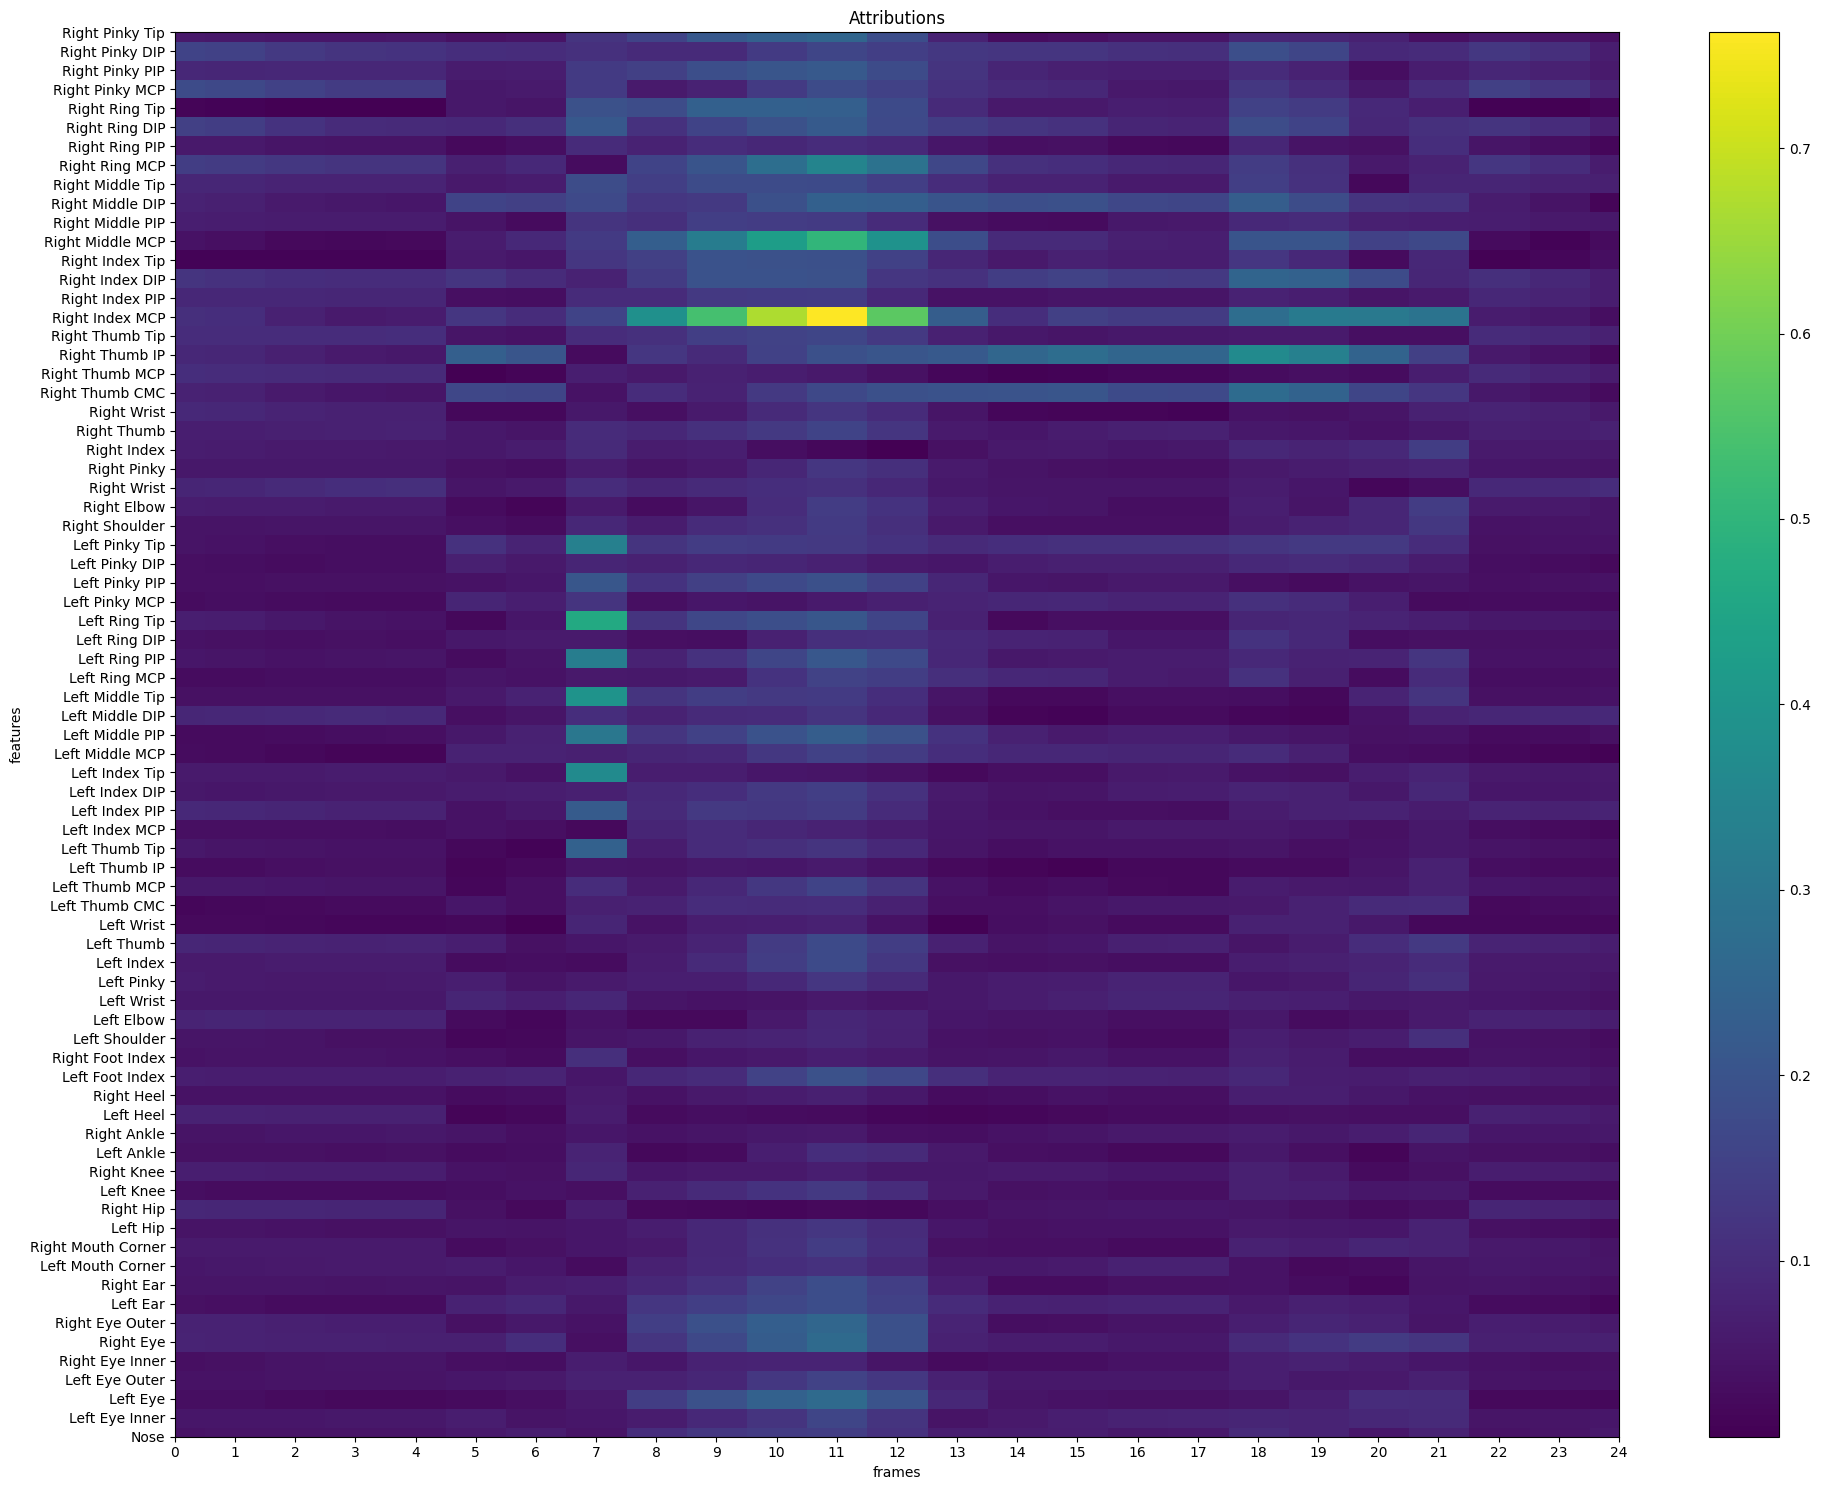

In [35]:
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection,
                                                     label= label,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= None, show_landmark_names= True)

  0%|          | 0/4000 [00:00<?, ?it/s]

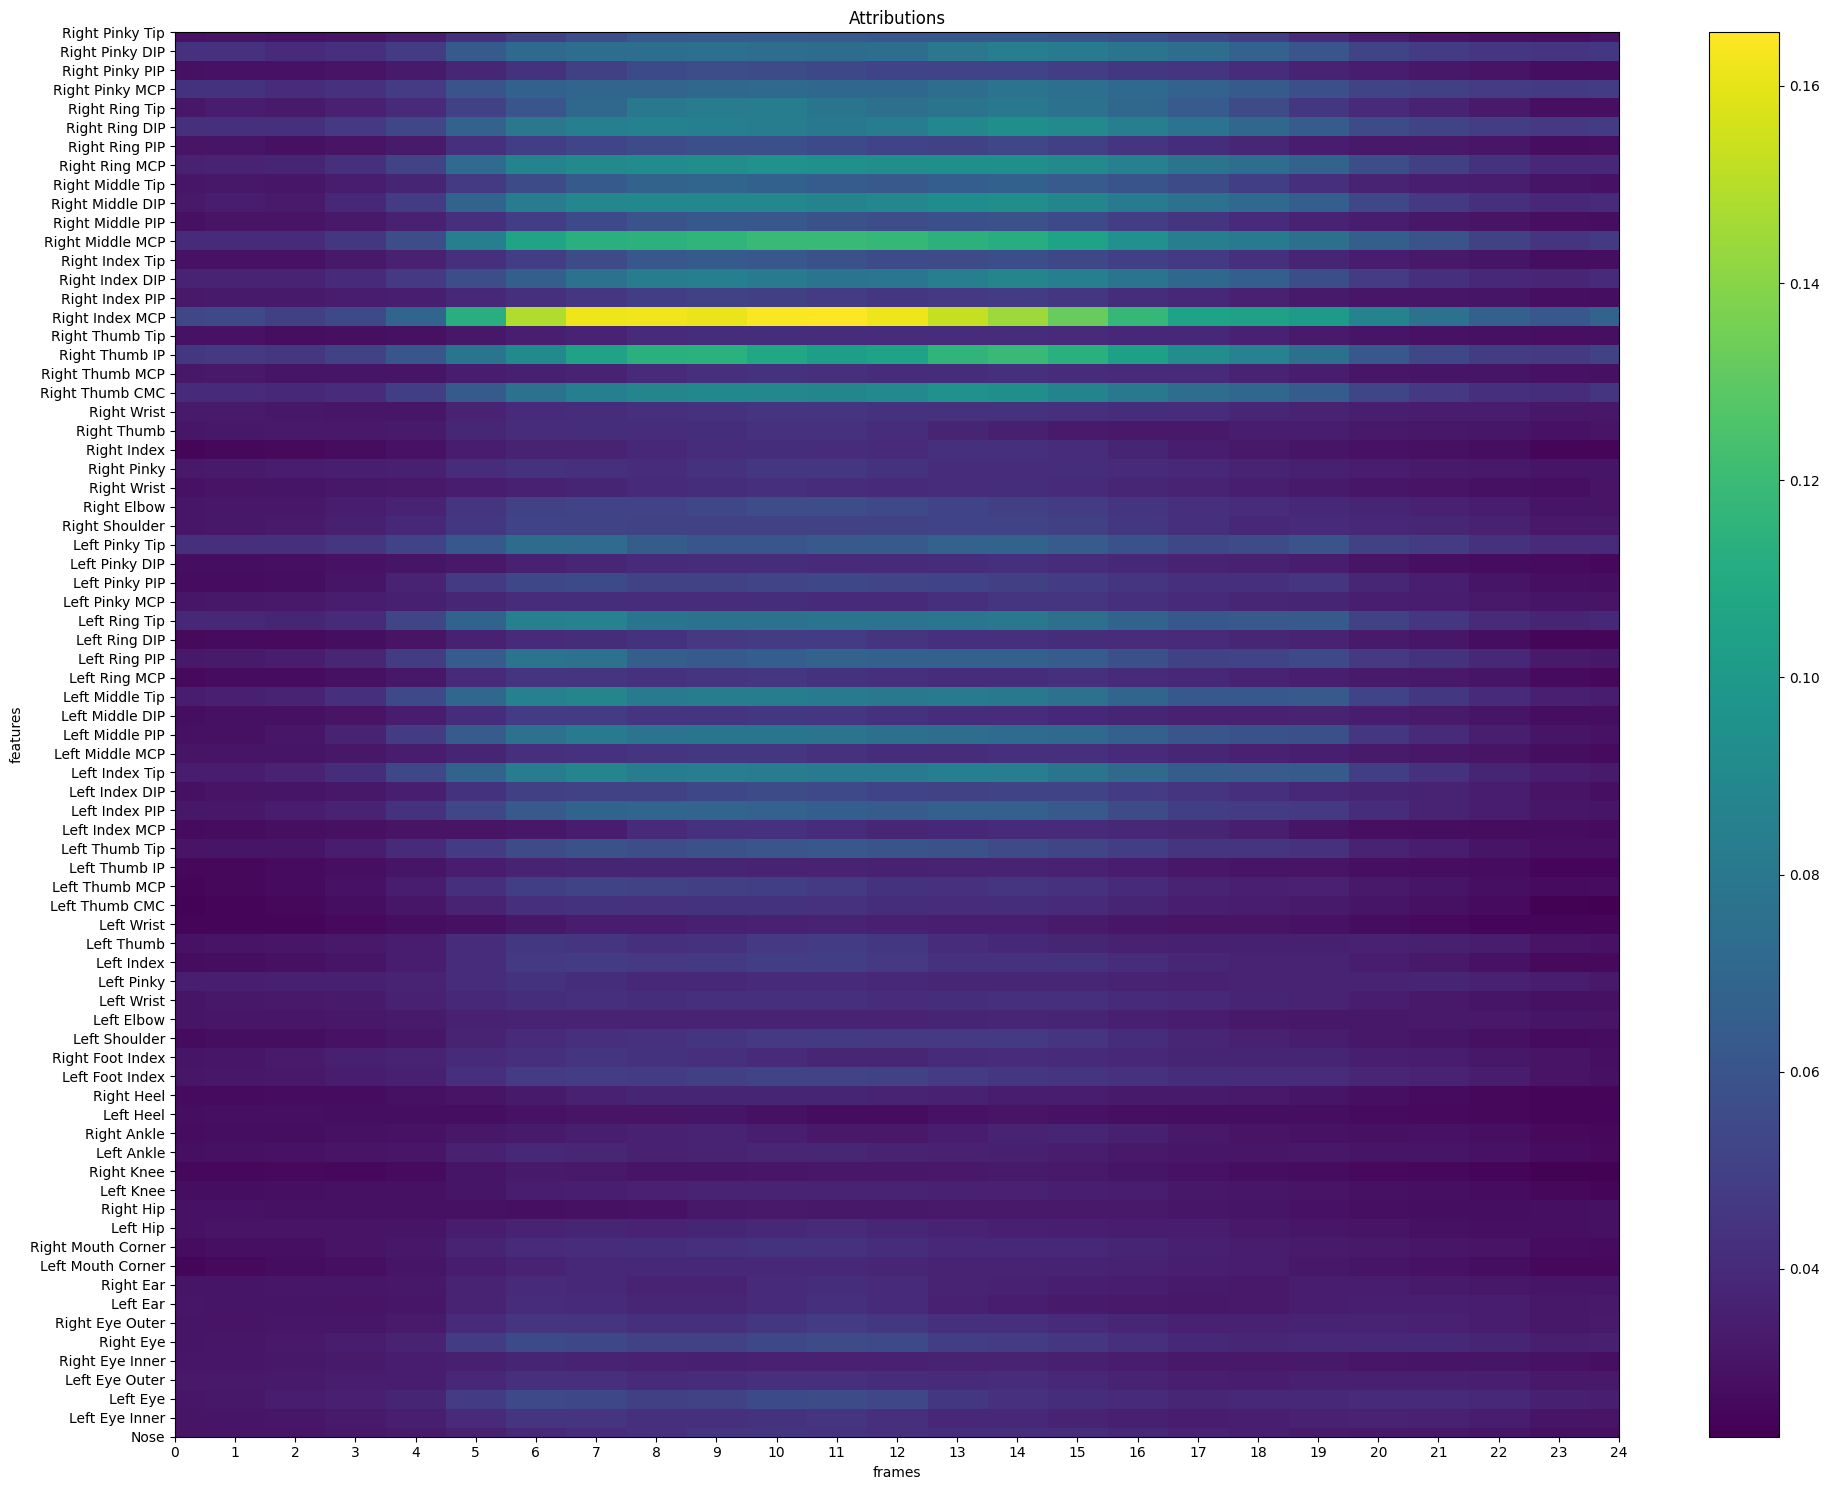

In [36]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= None, show_landmark_names= True)

# Calculating attributions based on words.

In [ ]:
from torch.utils.data import Subset

word_positions = defaultdict(list)
for i, (data, label) in enumerate(dataset):
    word_positions[label.item()].append(i)

for i in range(len(prepare_datasets.lsa64class_names)):
    subset_dataset = Subset(dataset, word_positions[i])  # Correct the variable name (i not I)
    lm_atts_word = analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                   captum_method= sailency,
                                                                   dataset= subset_dataset,
                                                                   device= device)
    
    analyse_layer.plot_atts_heatmap(attributions= lm_atts_word, save_path= None, show_landmark_names= True)

# Testing cross validation functions:

In [16]:
model_args = {'class_names': prepare_datasets.wlasl100class_names,
              'seq_len': 25,
              'd_model': 258,              
              'nhead': 6, 
              'd_ff': 512,                
              'num_layers': 2, 
              'dropout': 0.1}

------------------------------------------------------------------------------------------------------------------------------
Fold 1


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

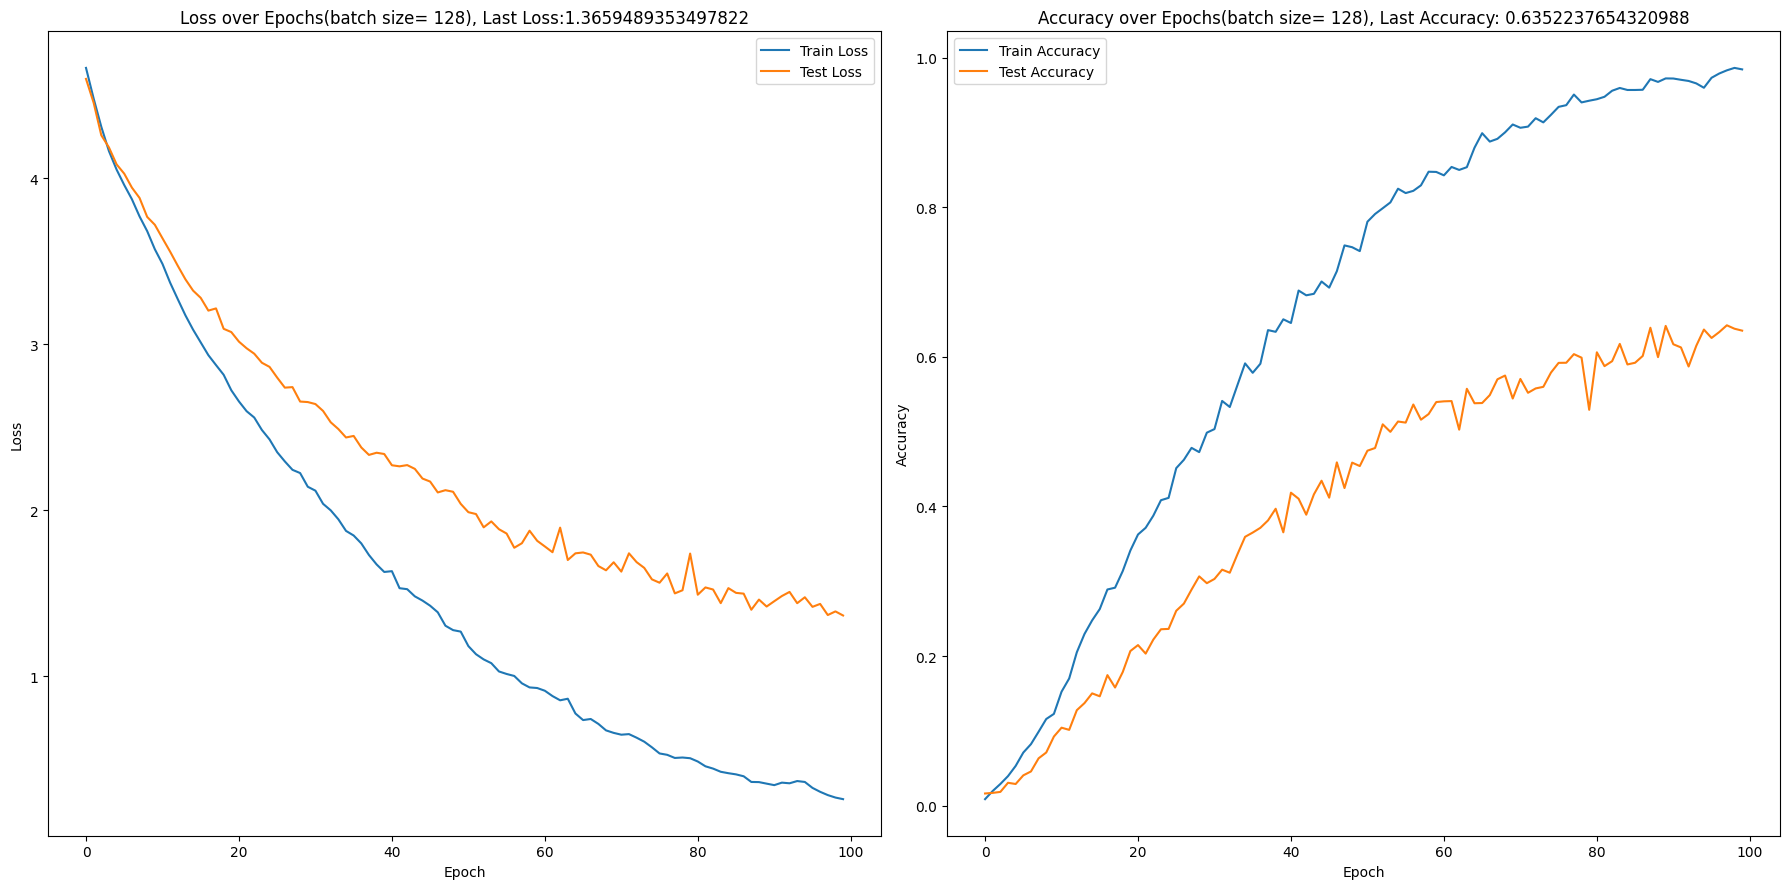

------------------------------------------------------------------------------------------------------------------------------
Fold 2


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

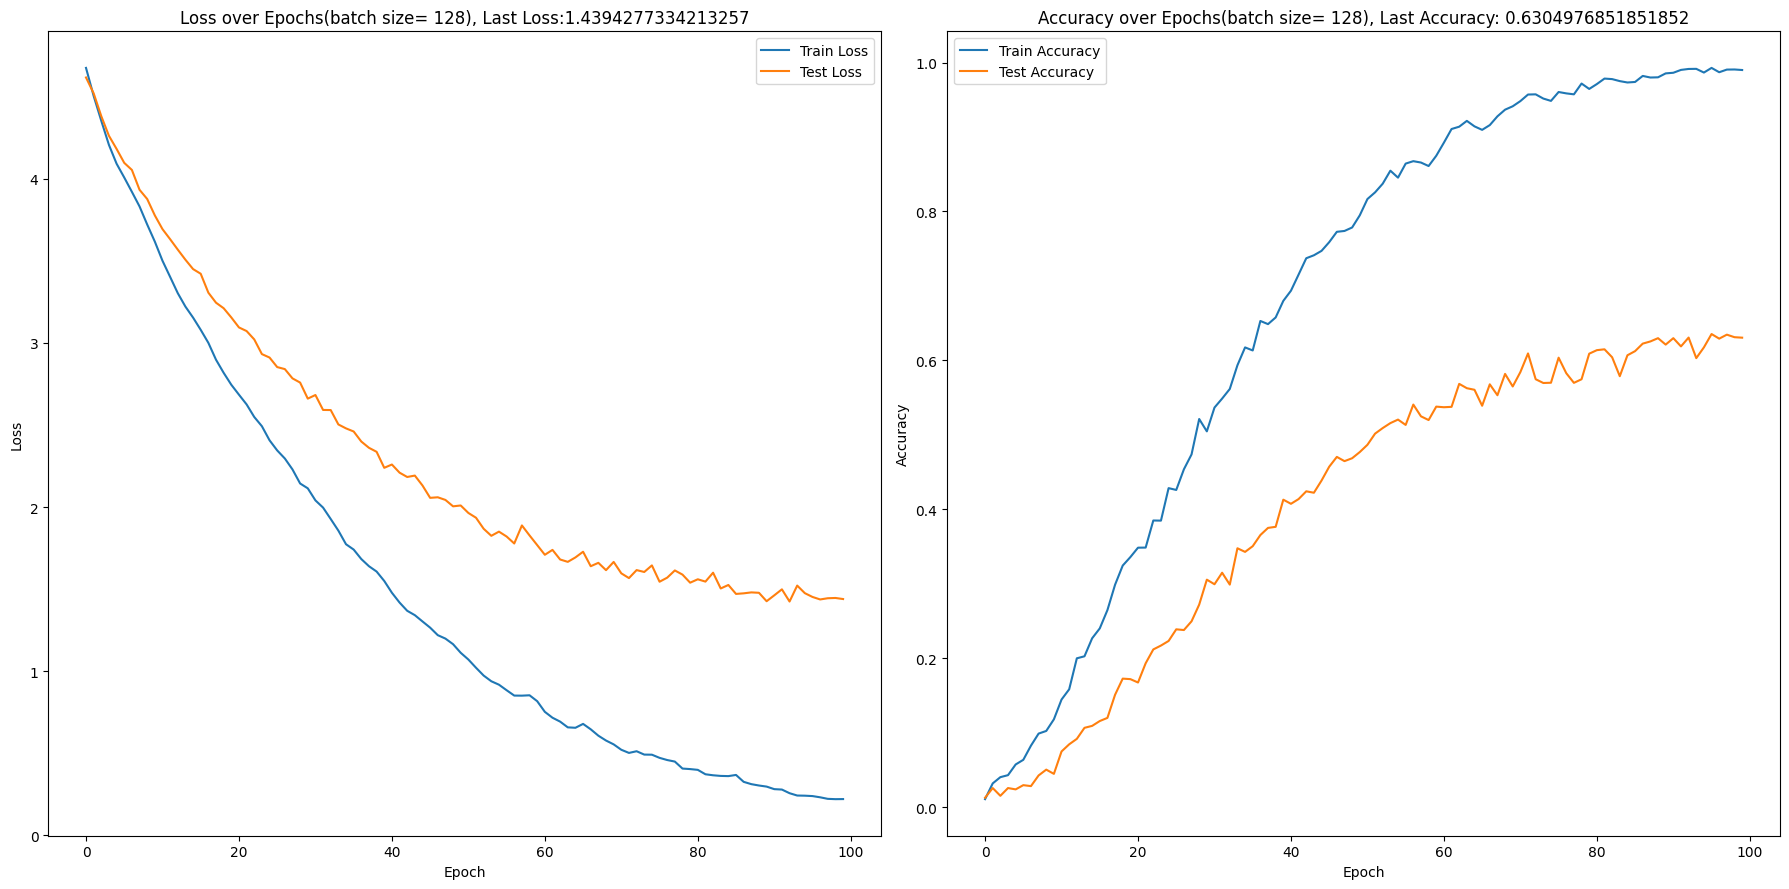

------------------------------------------------------------------------------------------------------------------------------
Fold 3


Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

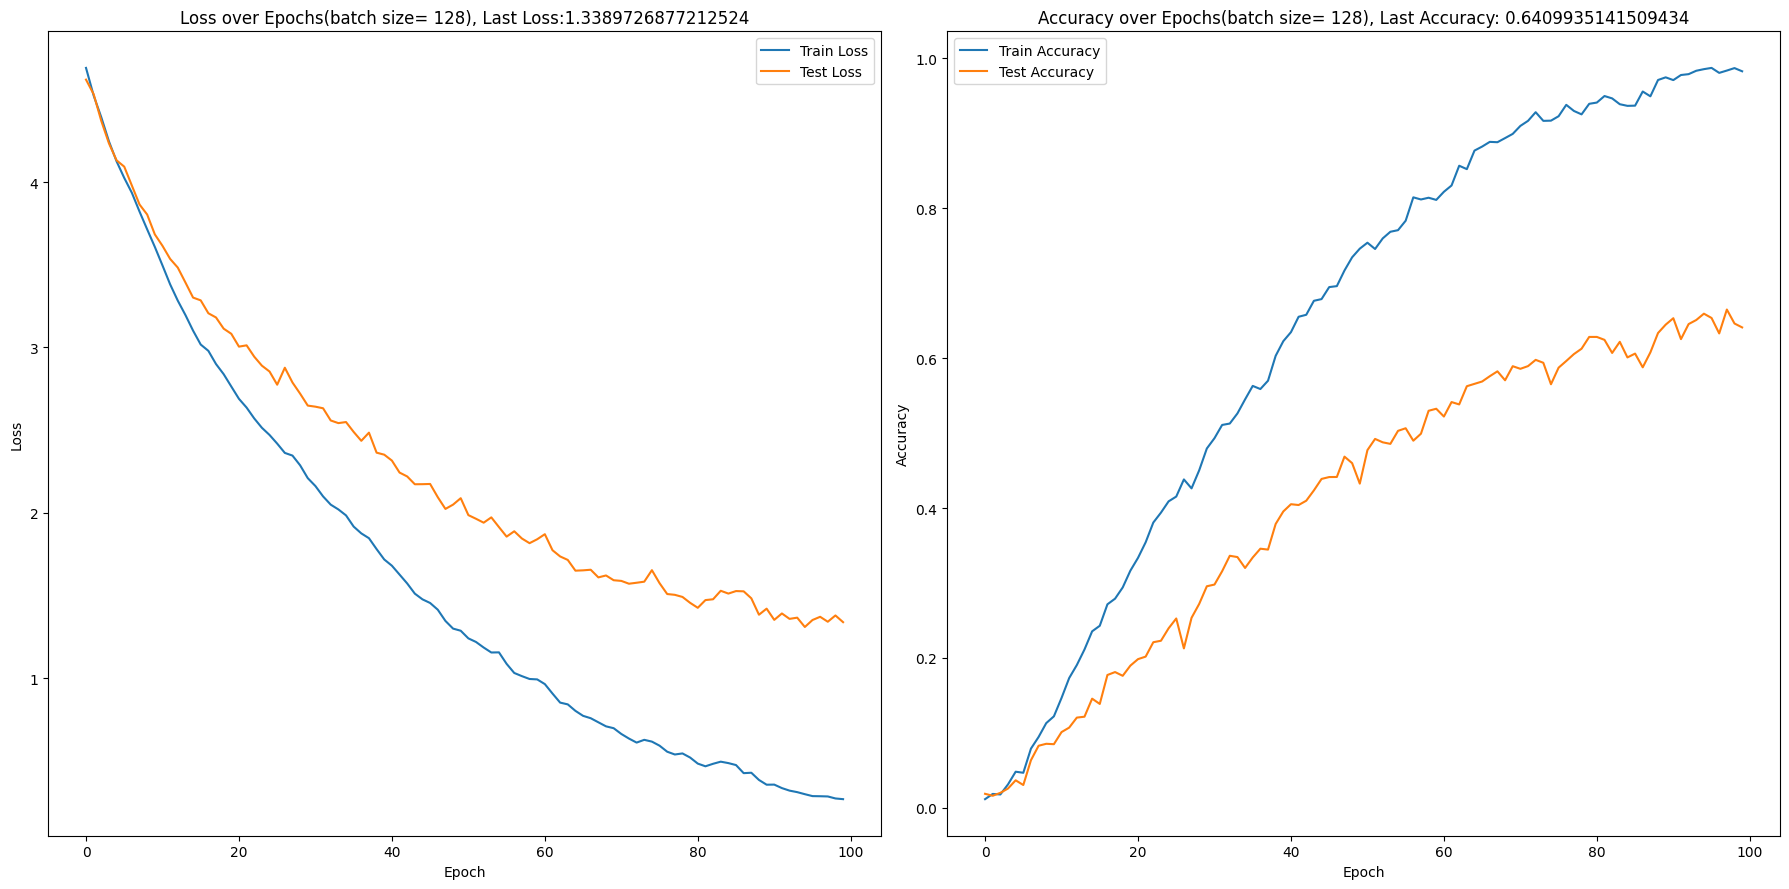

In [17]:
train.configure_Kfold(detections= filtered_detections,
                      labels= wlasl100_labels,
                      class_names= prepare_datasets.wlasl100class_names,
                      n_splits= 5,
                      batch_size= 128,
                      num_epochs= 100,
                      model_class= models.Transformer,
                      model_args= model_args,
                      lr= 0.0001,
                      device= device,
                      quick_save= False)